<a href="https://colab.research.google.com/github/DyatlovaA/cv-tf/blob/main/_2_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

# Шаг 1: Загрузка и предобработка данных

Если изображение не 224х224, то преобразуем его

Добавления шума

Загрузка и предобработка изображений

# Шаг 2: Создание автокодировщика

Кодировщик

Определение входного слоя

Сверточные слои и MaxPooling

Создание модели и вывод архитектуры

Латентное представление

Декодировщик


Создание моделей кодировщика и декодировщика

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
pip install kaggle

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Flatten, Dense, Reshape, Dropout, BatchNormalization, Conv2DTranspose, GlobalAveragePooling2D, ReLU
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
from glob import glob
import math

In [ ]:
from google.colab import files
uploaded = files.upload()
import zipfile
with zipfile.ZipFile('/content/archive (1).zip', 'r') as zip_ref:
    zip_ref.extractall('data')

Saving archive (1).zip to archive (1).zip


In [ ]:
# Параметры
BATCH_SIZE = 8
IMG_HEIGHT = 224
IMG_WIDTH = 224
NOISE_FACTOR = 0.4
EPOCHS = 20
DATA_DIR = '//content/data/raw-img/gatto'

In [ ]:
class MyDatasetSequence(tf.keras.utils.Sequence):
    def __init__(self, image_paths, batch_size, img_size, noise_factor):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.img_size = img_size
        self.noise_factor = noise_factor
        self.indexes = np.arange(len(self.image_paths))
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        images = np.array([self._load_image(self.image_paths[i]) for i in batch_indexes])
        noisy_images = self.add_gaussian_noise(images)
        return noisy_images.astype(np.float32), images.astype(np.float32)

    def _load_image(self, path):
        img = load_img(path)
        if img.size != (self.img_size[1], self.img_size[0]):
            img = img.resize((self.img_size[1], self.img_size[0]))
        return img_to_array(img) / 255.0

    def add_gaussian_noise(self, images):
        noise = np.random.normal(loc=0, scale=self.noise_factor, size=images.shape)
        return np.clip(images + noise, 0., 1.)


In [ ]:
class MyDataset:
    def __init__(self, image_path, batch_size=BATCH_SIZE, img_size=(IMG_HEIGHT, IMG_WIDTH),
                 noise_factor=NOISE_FACTOR, train_split=0.7, valid_split=0.2, test_split=0.1):
        assert math.isclose(train_split + valid_split + test_split, 1.0), "Сумма долей должна быть 1"

        self.image_paths = glob(os.path.join(image_path, '*.jpg')) + \
                         glob(os.path.join(image_path, '*.jpeg')) + \
                         glob(os.path.join(image_path, '*.png'))

        random.shuffle(self.image_paths)
        train_size = int(len(self.image_paths) * train_split)
        valid_size = int(len(self.image_paths) * valid_split)

        self.data_splits = {
            'train': MyDatasetSequence(self.image_paths[:train_size], batch_size, img_size, noise_factor),
            'valid': MyDatasetSequence(self.image_paths[train_size:train_size+valid_size], batch_size, img_size, noise_factor),
            'test': MyDatasetSequence(self.image_paths[train_size+valid_size:], batch_size, img_size, noise_factor)
        }

In [ ]:
def create_autoencoder(input_shape):
    inputs = Input(shape=input_shape)

    # Энкодер
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Декодер
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)

    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(inputs, outputs)


1. Загрузка данных...
   Загружено изображений: 1668

2. Проверка данных...
   Размер батча: (8, 224, 224, 3)
   Диапазон значений: 0.00-1.00

3. Создание модели...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 224, 224, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 3)         │           3,459 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 193,155 (754.51 KB)

 Trainable params: 192,387 (751.51 KB)

 Non-trainable params: 768 (3.00 KB)


4. Обучение модели...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 33s 148ms/step - loss: 0.0245 - val_loss: 0.1805 - learning_rate: 0.0010
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - loss: 0.0107 - val_loss: 0.0286 - learning_rate: 0.0010
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - loss: 0.0099 - val_loss: 0.0584 - learning_rate: 0.0010
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - loss: 0.0111 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - loss: 0.0098 - val_loss: 0.0244 - learning_rate: 0.0010
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - loss: 0.0088 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - loss: 0.0078 - val_loss: 0.0075 - learning_rate: 0.0010
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - loss: 0.0070 - val_loss: 0.0172 - learning_rate: 0.0010
Epoch 9/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0080
Epoch 9: ReduceLROnPlateau reducing

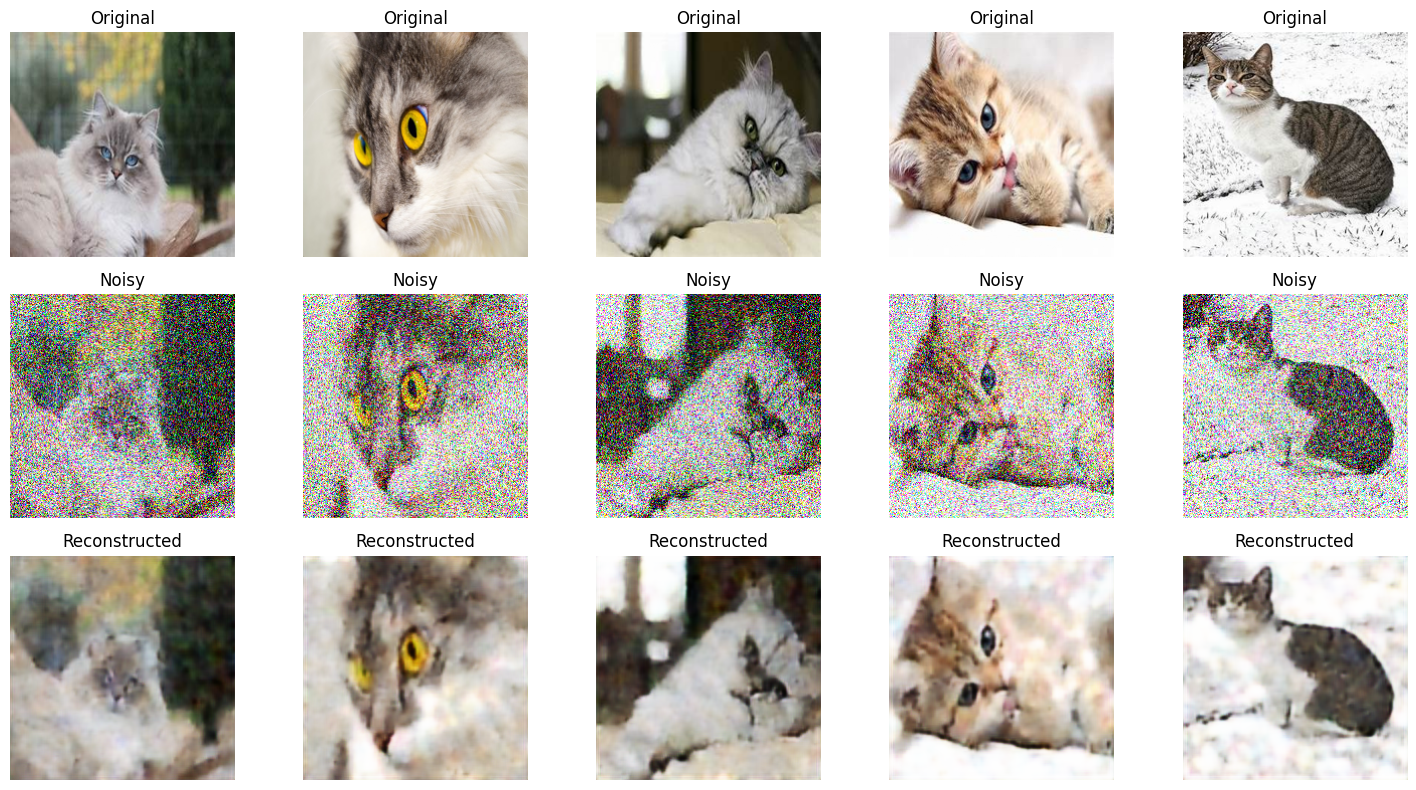

In [ ]:
def safe_psnr(original, reconstructed):
    try:
        return psnr(original, reconstructed, data_range=1.0)
    except:
        return float('nan')

def safe_ssim(original, reconstructed):
    try:
        return ssim(original, reconstructed, channel_axis=-1, data_range=1.0)
    except:
        return float('nan')

try:
    # Инициализация
    tf.keras.backend.clear_session()
    print("1. Загрузка данных...")
    data = MyDataset(DATA_DIR)
    print(f"   Загружено изображений: {len(data.image_paths)}")

    # Проверка данных
    print("\n2. Проверка данных...")
    sample_noisy, sample_original = next(iter(data.data_splits['train']))
    print(f"   Размер батча: {sample_noisy.shape}")
    print(f"   Диапазон значений: {sample_noisy.min():.2f}-{sample_noisy.max():.2f}")

    # Создание модели
    print("\n3. Создание модели...")
    autoencoder = create_autoencoder((IMG_HEIGHT, IMG_WIDTH, 3))
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()

    # Обучение
    print("\n4. Обучение модели...")
    history = autoencoder.fit(
        data.data_splits['train'],
        validation_data=data.data_splits['valid'],
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
        ],
        verbose=1
    )

    # Получение тестовых данных
    test_noisy, test_original = next(iter(data.data_splits['test']))
    reconstructed = autoencoder.predict(test_noisy)

    # Оценка с обработкой ошибок
    test_noisy, test_original = next(iter(data.data_splits['test']))
    reconstructed = autoencoder.predict(test_noisy)

    psnr_values = [safe_psnr(o, r) for o, r in zip(test_original, reconstructed)]
    ssim_values = [safe_ssim(o, r) for o, r in zip(test_original, reconstructed)]

    # Фильтрация NaN значений
    psnr_val = np.nanmean(psnr_values)
    ssim_val = np.nanmean(ssim_values)

    print("\nРезультаты:")
    print(f"PSNR: {psnr_val:.2f} dB")
    print(f"SSIM: {ssim_val:.4f}")

    # Визуализация графиков потерь на отдельной фигуре
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Визуализация изображений на отдельной фигуре
    plt.figure(figsize=(15, 8))
    n = 5  # Количество изображений для отображения
    for i in range(n):
        # Оригинальное изображение
        plt.subplot(3, n, i+1)
        plt.imshow(test_original[i])
        plt.title("Original")
        plt.axis('off')

        # Зашумленное изображение
        plt.subplot(3, n, i+n+1)
        plt.imshow(test_noisy[i])
        plt.title("Noisy")
        plt.axis('off')

        # Восстановленное изображение
        plt.subplot(3, n, i+2*n+1)
        plt.imshow(reconstructed[i])
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\nОшибка: {str(e)}")
    print("\nРекомендации:")
    print("1. Проверьте данные на корректность (нет ли битых изображений)")
    print("2. Уменьшите BATCH_SIZE до 4")
    print("3. Проверьте путь к данным:", DATA_DIR)


#РАЗДЕЛ 2: Усложнение 1ой модели по средством уменьшения латентного пространства

Хоть и уменьшили ЛП, но все же поднимим кол-во Батч сайзов и Эпох

In [ ]:
# Новые параметры
BATCH_SIZE_2 = 16
EPOCHS_2 = 40


Запуск второй модели с уменьшенным латентным пространством
Batch size: 16, Epochs: 40



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 202,691 (791.76 KB)

 Trainable params: 201,795 (788.26 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 193ms/step - loss: 0.0345 - val_loss: 0.0828 - learning_rate: 0.0010
Epoch 2/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step - loss: 0.0121 - val_loss: 0.2780 - learning_rate: 0.0010
Epoch 3/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - loss: 0.0088 - val_loss: 0.3314 - learning_rate: 0.0010
Epoch 4/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - loss: 0.0088 - val_loss: 0.3323 - learning_rate: 0.0010
Epoch 5/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0084
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - loss: 0.0084 - val_loss: 0.3123 - learning_rate: 0.0010
Epoch 6/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - loss: 0.0076 - val_loss: 0.2318 - learning_rate: 1.0000e-04
Epoch 7/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - loss: 0.0078 - val_loss: 0.0992 - learning_rate: 1.0000e-04
Epoch 8/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - loss: 0.0075 - val_loss: 0.

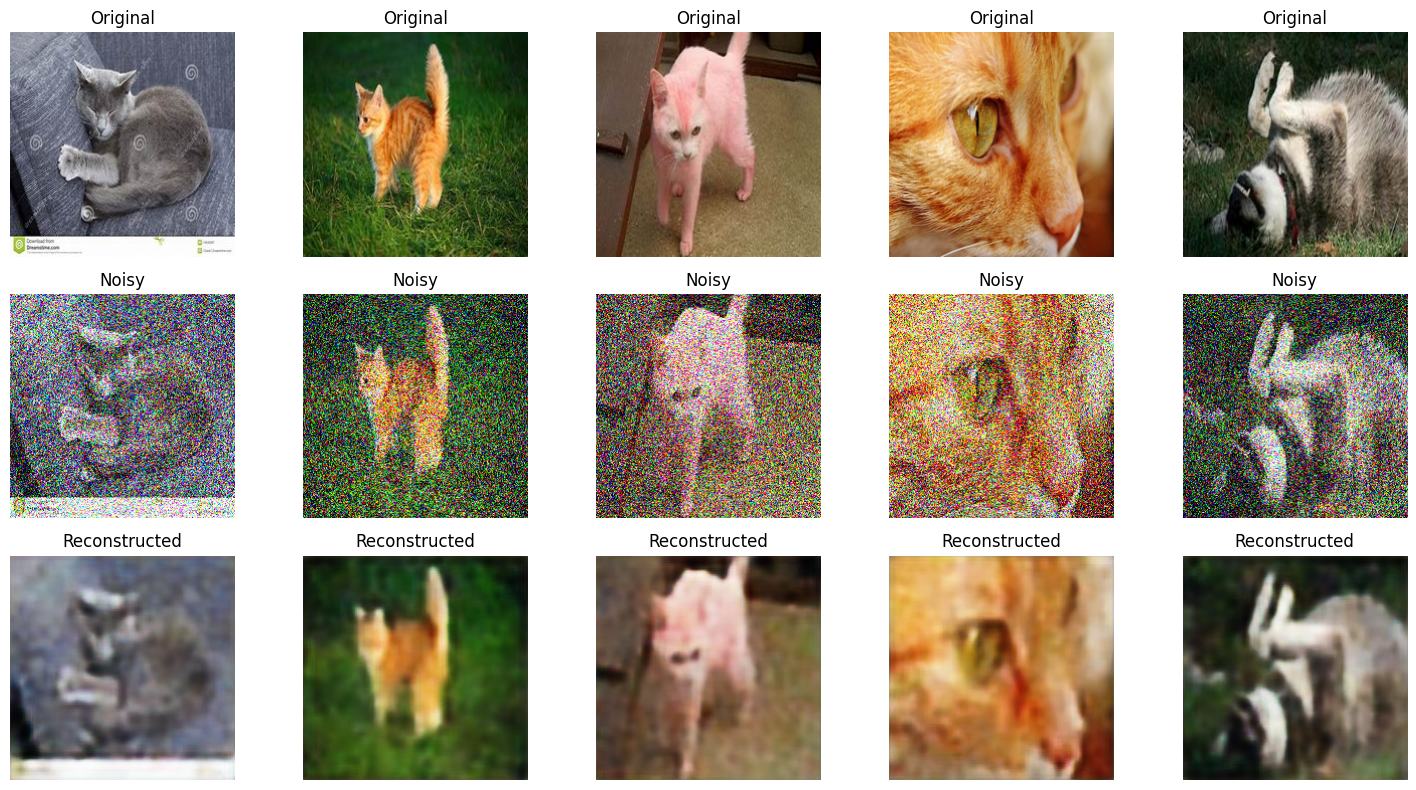

In [ ]:
def create_autoencoder_v2(input_shape):
    """Автоэнкодер с уменьшенным латентным пространством"""
    inputs = Input(shape=input_shape)

    # Энкодер (более агрессивное сжатие)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)  # 112x112

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)  # 56x56

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Добавлен новый слой
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)  # 28x28 (уменьшенное латентное пространство)

    # Декодер
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)  # 56x56

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)  # 112x112

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)  # 224x224

    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(inputs, outputs)

try:
    print("\n" + "="*50)
    print("Запуск второй модели с уменьшенным латентным пространством")
    print(f"Batch size: {BATCH_SIZE_2}, Epochs: {EPOCHS_2}")
    print("="*50 + "\n")

    # Инициализация
    tf.keras.backend.clear_session()

    # Используем тот же датасет, но с новым batch_size
    data_v2 = MyDataset(DATA_DIR, batch_size=BATCH_SIZE_2)

    # Создание модели v2
    autoencoder_v2 = create_autoencoder_v2((IMG_HEIGHT, IMG_WIDTH, 3))
    autoencoder_v2.compile(optimizer='adam', loss='mse')
    autoencoder_v2.summary()

    # Обучение с увеличенным количеством эпох
    history_v2 = autoencoder_v2.fit(
        data_v2.data_splits['train'],
        validation_data=data_v2.data_splits['valid'],
        epochs=EPOCHS_2,
        batch_size=BATCH_SIZE_2,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1)
        ],
        verbose=1
    )
     # Оценка модели
    test_noisy_v2, test_original_v2 = next(iter(data_v2.data_splits['test']))
    reconstructed_v2 = autoencoder_v2.predict(test_noisy_v2)

    psnr_values_v2 = [safe_psnr(o, r) for o, r in zip(test_original_v2, reconstructed_v2)]
    ssim_values_v2 = [safe_ssim(o, r) for o, r in zip(test_original_v2, reconstructed_v2)]

    psnr_val_v2 = np.nanmean(psnr_values_v2)
    ssim_val_v2 = np.nanmean(ssim_values_v2)

    print("\nРезультаты второй модели:")
    print(f"PSNR: {psnr_val_v2:.2f} dB")
    print(f"SSIM: {ssim_val_v2:.4f}")

    # Визуализация графиков потерь
    plt.figure(figsize=(12, 5))
    plt.plot(history_v2.history['loss'], label='Training Loss')
    plt.plot(history_v2.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss (Model v2)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # Визуализация изображений
    plt.figure(figsize=(15, 8))
    n = 5
    for i in range(n):
        plt.subplot(3, n, i+1)
        plt.imshow(test_original_v2[i])
        plt.title("Original")
        plt.axis('off')

        plt.subplot(3, n, i+n+1)
        plt.imshow(test_noisy_v2[i])
        plt.title("Noisy")
        plt.axis('off')

        plt.subplot(3, n, i+2*n+1)
        plt.imshow(reconstructed_v2[i])
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\nОшибка во второй модели: {str(e)}")
    print("\nРекомендации:")
    print("1. Проверьте, достаточно ли памяти для увеличенного batch size")
    print("2. Попробуйте уменьшить learning rate")
    print("3. Убедитесь, что данные загружены корректно")

#РАЗДЕЛ 3: Облегчение 1ой модели, увеличили Btch_size/Epochs/Latent, уменьшили шум

In [ ]:
################################################################
### РАЗДЕЛ 3: Исправленная модель с контролем размеров
################################################################

# Параметры
BATCH_SIZE_3 = 16
EPOCHS_3 = 30
LATENT_FILTERS = 256
WIN_SIZE = 7  # Размер окна для SSIM (должен быть меньше минимальной стороны изображения)
NOISE_FACTOR = 0.2

def build_autoencoder_v3(input_shape=(224, 224, 3)):
    """Автоэнкодер с контролем размеров"""
    inputs = Input(shape=input_shape)

    # Энкодер
    x = Conv2D(128, (3,3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)  # 112x112

    x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)  # 56x56

    # Латентное пространство
    x = Conv2D(LATENT_FILTERS, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)  # 28x28

    # Декодер
    x = Conv2DTranspose(256, (3,3), strides=2, padding='same')(x)  # 56x56
    x = BatchNormalization()(x)

    x = Conv2DTranspose(128, (3,3), strides=2, padding='same')(x)  # 112x112
    x = BatchNormalization()(x)

    outputs = Conv2DTranspose(3, (3,3), strides=2, padding='same',
                            activation='sigmoid')(x)  # 224x224

    return Model(inputs, outputs)

def calculate_ssim(img1, img2):
    """Безопасное вычисление SSIM с проверкой размеров"""
    min_side = min(img1.shape[:2])
    win_size = min(WIN_SIZE, min_side - 1) if min_side > 1 else 1
    win_size = win_size if win_size % 2 == 1 else win_size - 1

    if win_size < 1:
        return float('nan')

    return ssim(img1, img2, win_size=win_size, channel_axis=-1, data_range=1.0)

try:
    print("\n" + "="*70)
    print("Запуск исправленной модели с контролем размеров")
    print(f"Размер окна SSIM: {WIN_SIZE}x{WIN_SIZE}")
    print("="*70 + "\n")

    # Инициализация
    tf.keras.backend.clear_session()

    # Загрузка данных с проверкой
    data = MyDataset(DATA_DIR, batch_size=BATCH_SIZE_3)
    test_noisy, test_original = next(iter(data.data_splits['test']))

    # Проверка минимального размера изображений
    min_height = min(img.shape[0] for img in test_original)
    min_width = min(img.shape[1] for img in test_original)
    print(f"Минимальный размер в тестовых данных: {min_height}x{min_width}")

    if min_height < WIN_SIZE or min_width < WIN_SIZE:
        new_win_size = min(min_height, min_width) - 1
        new_win_size = new_win_size if new_win_size % 2 == 1 else new_win_size - 1
        print(f"Автокоррекция: win_size изменен на {new_win_size}")
        WIN_SIZE = max(1, new_win_size)

    # Создание модели
    autoencoder = build_autoencoder_v3()
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()

    # Обучение
    history = autoencoder.fit(
        data.data_splits['train'],
        validation_data=data.data_splits['valid'],
        epochs=EPOCHS_3,
        callbacks=[
            EarlyStopping(patience=10),
            ReduceLROnPlateau(factor=0.5, patience=5)
        ]
    )

    # Оценка качества
    reconstructed = autoencoder.predict(test_noisy)

    # Вычисление метрик с защитой от ошибок
    psnr_values = []
    ssim_values = []

    for i in range(len(test_original)):
        try:
            psnr_val = psnr(test_original[i], reconstructed[i], data_range=1.0)
            ssim_val = calculate_ssim(test_original[i], reconstructed[i])

            psnr_values.append(psnr_val)
            ssim_values.append(ssim_val)
        except Exception as e:
            print(f"Ошибка для изображения {i}: {str(e)}")
            continue

    print("\nРезультаты (на основе", len(psnr_values), "корректных изображений):")
    print(f"PSNR: {np.nanmean(psnr_values):.2f} ± {np.nanstd(psnr_values):.2f} dB")
    print(f"SSIM: {np.nanmean(ssim_values):.4f} ± {np.nanstd(ssim_values):.4f}")
    print(f"Использованный win_size: {WIN_SIZE}")

    # Визуализация
    plt.figure(figsize=(15, 9))
    for i in range(min(3, len(test_original))):
        plt.subplot(3, 3, i+1)
        plt.imshow(test_original[i])
        plt.title("Original")
        plt.axis('off')

        plt.subplot(3, 3, i+4)
        plt.imshow(test_noisy[i])
        plt.title("Noisy")
        plt.axis('off')

        plt.subplot(3, 3, i+7)
        plt.imshow(reconstructed[i])
        if i < len(psnr_values):
            plt.title(f"Recon\nPSNR:{psnr_values[i]:.2f}\nSSIM:{ssim_values[i]:.4f}")
        else:
            plt.title("Reconstructed (метрики недоступны)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\nКритическая ошибка: {str(e)}")
    print("\nРекомендации:")
    print("1. Проверьте размеры изображений в DATA_DIR")
    print("2. Убедитесь, что все изображения больше 7x7 пикселей")
    print("3. Для маленьких изображений уменьшите WIN_SIZE")


Запуск исправленной модели с контролем размеров
Размер окна SSIM: 7x7

Минимальный размер в тестовых данных: 224x224


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 112, 112, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 224, 224, 3)         │           3,459 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,781,507 (6.80 MB)

 Trainable params: 1,779,459 (6.79 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - loss: 0.0220 - val_loss: 0.2434 - learning_rate: 0.0010
Epoch 2/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 172ms/step - loss: 0.0084 - val_loss: 0.2674 - learning_rate: 0.0010
Epoch 3/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step - loss: 0.0075 - val_loss: 0.2809 - learning_rate: 0.0010
Epoch 4/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 170ms/step - loss: 0.0075 - val_loss: 0.2458 - learning_rate: 0.0010
Epoch 5/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 172ms/step - loss: 0.0069 - val_loss: 0.2175 - learning_rate: 0.0010
Epoch 6/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - loss: 0.0068 - val_loss: 0.0251 - learning_rate: 0.0010
Epoch 7/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 169ms/step - loss: 0.0067 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 8/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 190ms/step - loss: 0.0063 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 9/30
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 182ms/step - loss: 0.0064 - val_loss: 0.0048 - learning_rate: 0.0010
E